In [1]:
from simulated_stack_new16 import data_loader, load_all_data, plot_data, save_predictions_as_tifs

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import re
import argparse

tf.random.set_seed(42)
os.environ['TF_DETERMINISTIC_OPS'] = '0'
os.environ['CUDA_VISIBLE_DEVICES'] = '0, 1, 2'

parser = argparse.ArgumentParser(description='Sentinel Processing Wrapper')
parser.add_argument('-s', type=int, dest='start', default=None,
  help='Specify the start step in the config file. eg: -s Function-4')
parser.add_argument('-e', type=int, dest='end', default=None,
  help='Specify the end step in the config file. eg: -e Function-8')
args = parser.parse_known_args()[0]

data_dir = 'training_data/'
model_out = 'denoiser/donised_CNN_InSAR'
model_weights_out = 'denoiser/donised_CNN_InSAR.h5'
train_out = 'train_out/'


2023-08-11 17:19:36.344148: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [50]:
args.start=1000
args.end=1099

initialize_model = True ### Setting True when from number=00*; else False
nums = list()
ssimss = list()
mssimss = list()
nrmses = list()
snrs = list()
# X, y = load_all_data(data_dir + "simulated_stack0*.h5", data_dir + "elevation_looked.dem", normalize=False)
for i in range(1):
    sim_file_list = list()
    dem_file_list = list()
    for number in range(0, 1): ###
        for j in range(args.start, args.end):
            sim_file_list.append(data_dir + "simulated_stack_%01i.h5"%j)
            dem_file_list.append(data_dir + "maduocut_%01i.tif"%j)
    X, y, snr = load_all_data(sim_file_list=sim_file_list, dem_file_list=dem_file_list, normalize=False)

    print(X.shape, y.shape)
    y = np.moveaxis(y, 1, -1)
    X = np.expand_dims(X, -1)
    print(X.shape, y.shape)

    X_train, X_test, y_train, y_test, snr_train, snr_test = train_test_split(X, y, snr, test_size=0.2, random_state=42)
    snrs.extend(snr_test)

    print(np.max(np.abs(y_train)))
    print(np.max(np.abs(y_test)))

    class MeanMaxScaler:
        def __init__(self):
            pass

        def fit(self, X):
            self.mean_ = np.average(X)
            self.scale_ = np.max(np.abs(X - self.mean_))
            return self
        
        def transform(self, X):
            return (X - self.mean_)/self.scale_
    
        def inverse_transform(self, X):
            return X * self.scale_ + self.mean_


    class MeanPctScaler:
        """Since the data is so skewed, use a high percentile instead of max."""
        def __init__(self, pctile=95):
            self.percentile = pctile
            pass

        def fit(self, X):
            self.mean_ = np.average(X)
            self.scale_ = np.percentile(np.abs(X - self.mean_), self.percentile)
            return self
        
        def transform(self, X):
            return (X - self.mean_)/self.scale_
    
        def inverse_transform(self, X):
            return X * self.scale_ + self.mean_


    class LogMeanScaler:
        """Can work well to normalize skewed data, I tried it but no huge improvement at least on very noisy data."""
        def __init__(self):
            pass

        def fit(self, X):
            self.shift_ = (0 if np.min(X) >= 0 else -np.min(X)) + .0001 # log10(0) is undefined so slight shift
            self.mean_ = np.average(np.log(X + self.shift_))
            return self
        
        def transform(self, X):
            return np.log(X + self.shift_) - self.mean_
    
        def inverse_transform(self, X):
            return np.exp(X + self.mean_) - self.shift_
    
    def unstack_dem_timeseries(X):
        dems = X[..., :1, :, :, :]
        timeseries = X[..., 1:, :, :, :]
        return dems, timeseries

    def stack_dem_timeseries(dems, timeseries):
        return np.concatenate((dems, timeseries), axis=1)

    train_dems, train_timeseries = unstack_dem_timeseries(X_train)
    test_dems, test_timeseries = unstack_dem_timeseries(X_test)

    dem_scaler = MeanPctScaler().fit(train_dems)
    scaled_train_dems = dem_scaler.transform(train_dems)
    scaled_test_dems = dem_scaler.transform(test_dems)
    print(scaled_train_dems.shape)

    print(train_dems.min(), train_dems.max())
    print(test_dems.min(), test_dems.max())

    print(scaled_train_dems.min(), scaled_train_dems.max())
    print(scaled_test_dems.min(), scaled_test_dems.max())

    timeseries_scaler = MeanPctScaler().fit(train_timeseries)
    scaled_train_timeseries = timeseries_scaler.transform(train_timeseries)
    scaled_test_timeseries = timeseries_scaler.transform(test_timeseries)
    print(scaled_train_timeseries.shape)

    print(train_timeseries.min(), train_timeseries.max())
    print(test_timeseries.min(), test_timeseries.max())

    print(scaled_train_timeseries.min(), scaled_train_timeseries.max())
    print(scaled_test_timeseries.min(), scaled_test_timeseries.max())

    # normalize targets
    scaled_y_train = timeseries_scaler.transform(y_train)
    scaled_y_test = timeseries_scaler.transform(y_test)
    print(scaled_y_train.shape)

    print(y_train.max(), y_train.min())
    print(y_test.max(), y_test.min())
    print(scaled_y_train.max(), scaled_y_train.min())
    print(scaled_y_test.max(), scaled_y_test.min())

    scaled_X_train = stack_dem_timeseries(scaled_train_dems, scaled_train_timeseries)
    scaled_X_test = stack_dem_timeseries(scaled_test_dems, scaled_test_timeseries)
    print(scaled_X_train.shape)

    if initialize_model:
        num_filters = 64
        conv_kernel = (4, 3, 3)
        pooling_kernel = (4, 1, 1) ###
        activation = layers.LeakyReLU(alpha=0.1)
        padding = "same"

        # Input
        px = None  # can hardcode as 48
        model_input = layers.Input(shape=(17, px, px, 1))
        timeseries_input = model_input[..., 1:, :, :, :]
        dem_input = model_input[..., :1, :, :, :]
        timeseries_input.shape, dem_input.shape
        dropout_rate = 0.0
        
        # encoder
        # 4 convolution layers with dropout
        conv_1 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(timeseries_input)
        conv_1 = layers.Dropout(dropout_rate)(conv_1)
        conv_2 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_1)
        conv_2 = layers.Dropout(dropout_rate)(conv_2)
        conv_3 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_2)
        conv_3 = layers.Dropout(dropout_rate)(conv_3)
        conv_4 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_3)
        conv_4 = layers.Dropout(dropout_rate)(conv_4)
        
        # 1 pooling layer
        pool_5 = layers.MaxPooling3D(pooling_kernel, padding=padding)(conv_4)
        
        # 1 convolution layer with dropout
        conv_6 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(pool_5)
        conv_6 = layers.Dropout(dropout_rate)(conv_6)
        conv_6 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_6)
        conv_6 = layers.Dropout(dropout_rate)(conv_6)
        
        # 1 pooling layer
        pool_7 = layers.MaxPooling3D(pooling_kernel, padding=padding)(conv_6)
        
        # 1 pooling layer
        pool_9 = layers.UpSampling3D(size=pooling_kernel)(pool_7)
        
        # 1 convolution layer with dropout
        conv_10 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(pool_9)
        conv_10 = layers.Dropout(dropout_rate)(conv_10)
        conv_10 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_10)
        conv_10 = layers.Dropout(dropout_rate)(conv_10)
        
        # 1 pooling layer
        pool_11 = layers.UpSampling3D(size=pooling_kernel)(conv_10)
        dem_plus_pool = layers.Concatenate(axis=-1)([pool_11, tf.tile(dem_input, [1, 16, 1, 1, 1])])
        
        # 4 convolution layers with dropout
        conv_12 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(dem_plus_pool)
        conv_12 = layers.Dropout(dropout_rate)(conv_12)
        conv_13 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_12)
        conv_13 = layers.Dropout(dropout_rate)(conv_13)
        conv_14 = layers.Conv3D(num_filters, conv_kernel, activation=activation, padding=padding)(conv_13)
        conv_14 = layers.Dropout(dropout_rate)(conv_14)
        
        output = layers.Conv3D(1, conv_kernel, activation="linear", padding=padding)(conv_14)

        # Autoencoder
        # again from https://keras.io/examples/vision/autoencoder/
        autoencoder = Model(model_input, output)
    else:
        autoencoder = tf.keras.models.load_model(model_out, compile=False)

    def Loss(y_true, y_pred):
        y_pred = tf.transpose(y_pred, perm=[0, 2, 3, 1])
        ssim = tf.image.ssim(y_true, y_pred, max_val=5)
        rmse = tf.sqrt(tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(y_true, y_pred))
        nrmse = tf.reduce_mean((rmse - tf.reduce_mean(rmse)) / tf.math.reduce_std(y_pred))
        print(1 - ssim, nrmse)
        return 1 - ssim + nrmse
    loss = Loss
    # loss = "mae" # -- what the original paper uses, according to their supplementary information.
    # For us it resulted in odd grid artifacts in the corners.

    autoencoder.compile(optimizer="adam", loss=loss)
    autoencoder.summary()

    tb_callback = tf.keras.callbacks.TensorBoard(
        log_dir=train_out + "logs",
        histogram_freq=2,
        update_freq="epoch",
        write_graph=True,
        write_images=True,
    )
    my_callbacks = [
        tf.keras.callbacks.ModelCheckpoint(filepath=train_out + 'model.{epoch:02d}.h5'),
        tb_callback,
    ]

    # https://keras.io/examples/vision/autoencoder/

    autoencoder.fit(
        x=scaled_X_train,
        y=scaled_y_train,
        epochs=100,   # 10 - 30 is fine on low/no noise data, 100+ needed on higher noise data (watch for overtraining)
        batch_size=10, ###
        shuffle=True,
        validation_data=(scaled_X_test, scaled_y_test),
        callbacks=my_callbacks
    )

    autoencoder.save_weights(model_weights_out)
    autoencoder.save(model_out)

    predictions_scaled = autoencoder.predict(scaled_X_test)
    predictions_vis = timeseries_scaler.inverse_transform(predictions_scaled)
    predictions = tf.transpose(tf.squeeze(predictions_vis, -1), (0, 2, 3, 1))
    print(np.max(np.abs(predictions_scaled)))
    print(np.max(np.abs(predictions)))

    """
    def plot_data_cust(X, y, output, name, n=9, vm=None, cmap='RdBu'):
        vm = vm or np.max(np.abs(X))/1.0
        fig = plt.figure(constrained_layout=True, figsize=(16, 16), dpi=300)
        grid = plt.GridSpec(5, 12)
        ax11 = []
        for i in range(4):
            for j in range(4):
                ax11.append(fig.add_subplot(grid[i, j]))
        ax12 = []
        for i in range(4):
            for j in range(4, 8):
                ax12.append(fig.add_subplot(grid[i, j]))
        ax13 = []
        for i in range(4):
            for j in range(8, 12):
                ax13.append(fig.add_subplot(grid[i, j]))
        ax21 = fig.add_subplot(grid[4: 5, : 4])
        ax22 = fig.add_subplot(grid[4: 5, 4: 8])
        ax23 = fig.add_subplot(grid[4: 5, 8: 12])
        
        for a in range(4):
            for b in range(4):
                i = 4 * a + b
                ax11[i].imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
        for a in range(4):
            for b in range(4):
                i = 4 * a + b
                axim = ax13[i].imshow(output[i], cmap=cmap, vmin=-vm, vmax=vm)
        if y is not None:
            for a in range(4):
                for b in range(4):
                    i = 4 * a + b
                    ax12[i].imshow(y[i], cmap=cmap, vmin=-vm, vmax=vm)
            index = np.unravel_index(np.argmax(y), y.shape)
            xs = []
            outputs = []
            ys = []
            for i in range(16):
                xs.append(X[i, index[1], index[2]])
                outputs.append(output[i, index[1], index[2]])
                ys.append(y[i, index[1], index[2]])
            ax21.scatter(list(range(1, 17)), xs)
            ax22.scatter(list(range(1, 17)), ys)
            ax23.scatter(list(range(1, 17)), outputs)
            ax21.plot(list(range(1, 17)), xs)
            ax22.plot(list(range(1, 17)), ys)
            ax23.plot(list(range(1, 17)), outputs)
            fig.savefig('prediction_%02d_%s.jpg'%(number, name))
        else:
            fig.savefig('prediction_%s.jpg'%name)
    """
    def avg_ssim(pred_img, target_img):
        """Take the SSIM for each prediction - target pair in the test set, and return the average
        across the entire test set"""
        return float(tf.image.ssim(pred_img, target_img, 2, filter_size=8))

    # the paper appears to be using MSSIM not SSIM, but they are not taking the average anywhere
    # that's something I'm doing to get a nice single metric to use to evaluate the different
    # model runs I'm doing. 

    def avg_mssim(pred_img, target_img):
        """For each prediction-target pair in the set, take 8x8 windows, calculate SSIM, average
        across the image, then average across the entire test set"""
        # make patches
        filter_dims = (1,8,8,1)
        rates = (1,1,1,1)
        
        pred_img = tf.reshape(pred_img, (pred_img.shape[0], 96, 96, 16))
        preds_patches = tf.image.extract_patches(pred_img,
                                                 sizes=filter_dims,
                                                 strides=filter_dims,
                                                 rates=rates,
                                                 padding='VALID')
        preds_patches = np.array(preds_patches).reshape(preds_patches.shape[0] * 16, 72, 128)
        preds_patches = preds_patches.reshape(-1, 144, 8, 8)
        
        target_img = tf.reshape(target_img, (target_img.shape[0], 96, 96, 16))
        targs_patches = tf.image.extract_patches(target_img,
                                                 sizes=filter_dims,
                                                 strides=filter_dims,
                                                 rates=rates,
                                                 padding='VALID')
    
        # reshape for needed sizes for SSIM
        targs_patches = np.array(targs_patches).reshape(targs_patches.shape[0] * 16, 72, 128)
        targs_patches = targs_patches.reshape(-1, 144, 8, 8)
    
        # run SSIM for patches
        local_ssims = tf.image.ssim(preds_patches, targs_patches, max_val=2, filter_size=3)
        return np.average(local_ssims)

    for i in range(scaled_X_test.shape[0]): # change this seed and rerun this cell to see different examples
        x_img = X_test[i][1:]   # X_test is unscaled
        targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
        y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
        print("Max target deformation: ", np.max(targ_img))

        ssim = avg_ssim(y_img, targ_img)
        ssimss.append(ssim)
        print('ssim', ssim)
        mssim = avg_mssim(tf.expand_dims(y_img, axis=0), tf.expand_dims(targ_img, axis=0))
        mssimss.append(mssim)
        print('mssim', mssim)
        rmse = tf.sqrt(tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.NONE)(targ_img, y_img))
        nrmse = tf.reduce_mean((rmse - tf.reduce_mean(rmse)) / tf.math.reduce_std(rmse))
        nrmses.append(nrmse)
        print('nrmse', nrmse)
        del x_img, targ_img, y_img
print('mean ssim', np.mean(ssimss))
print('mean mssim', np.mean(mssimss))
print('mean nrmse', np.mean(nrmses))
pd.DataFrame({'Number': list(range(len(ssimss))), 'ssim': ssimss, 'mssim': mssimss, 'snr': snrs, 'nrmse': nrmses}).to_csv(train_out + 'prediction_ssim_snr_%s.txt'%args.start, index=False, header=None, sep=' ')

  0%|                                                    | 0/99 [00:00<?, ?it/s]/home/lichenglong/miniconda3/envs/troposim/lib/python3.8/site-packages/rasterio/__init__.py:277: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)
100%|███████████████████████████████████████████| 99/99 [00:03<00:00, 32.98it/s]


(99, 17, 96, 96) (99, 16, 96, 96)
(99, 17, 96, 96, 1) (99, 96, 96, 16)
50.784348
15.185127
(79, 1, 96, 96, 1)
4193.0 5121.0
4207.0 5139.0
-0.7326115551730933 1.983374125909053
-0.6916376332602161 2.036054882654181
(79, 16, 96, 96, 1)
-18.40546194743365 50.749456719495356
-11.982137959450483 15.107894279062748
-60.420088041109565 166.5976447310835
-39.3339747649686 49.595602741047344
(79, 96, 96, 16)
50.784348 -18.37424
15.185127 -11.990395
166.71217 -60.317596
49.849136 -39.36108
(79, 17, 96, 96, 1)
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 17, None, No 0                                            
__________________________________________________________________________________________________
tf.__operators__.getitem_2 (Sli (None, 16, None, Non 0           input_2[0][0]    

2023-08-11 17:41:46.493069: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-08-11 17:41:46.493097: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.
2023-08-11 17:41:47.715489: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-08-11 17:41:47.715655: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed


Epoch 1/100
Tensor("Loss/sub_1:0", shape=(None,), dtype=float32) Tensor("Loss/Mean_1:0", shape=(), dtype=float32)
Tensor("Loss/sub_1:0", shape=(None,), dtype=float32) Tensor("Loss/Mean_1:0", shape=(), dtype=float32)
1/8 [==>...........................] - ETA: 16s - loss: 0.6470

2023-08-11 17:41:50.383705: I tensorflow/core/profiler/lib/profiler_session.cc:136] Profiler session initializing.
2023-08-11 17:41:50.383731: I tensorflow/core/profiler/lib/profiler_session.cc:155] Profiler session started.


2/8 [======>.......................] - ETA: 10s - loss: 0.6791

2023-08-11 17:41:52.161527: I tensorflow/core/profiler/lib/profiler_session.cc:71] Profiler session collecting data.
2023-08-11 17:41:52.166027: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1487] CUPTI activity buffer flushed
2023-08-11 17:41:52.292077: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:228]  GpuTracer has collected 6569 callback api events and 6561 activity events. 
2023-08-11 17:41:52.408269: I tensorflow/core/profiler/lib/profiler_session.cc:172] Profiler session tear down.
2023-08-11 17:41:52.510554: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: train_out/logs/train/plugins/profile/2023_08_11_17_41_52
2023-08-11 17:41:52.590432: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to train_out/logs/train/plugins/profile/2023_08_11_17_41_52/dell-PowerEdge-R740.trace.json.gz
2023-08-11 17:41:52.663805: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creatin

8/8 [==============================] - 11s 1s/step - loss: 0.8263 - val_loss: 0.7492
Epoch 2/100
8/8 [==============================] - 7s 939ms/step - loss: 0.7882 - val_loss: 0.7815
Epoch 3/100
8/8 [==============================] - 7s 943ms/step - loss: 0.7655 - val_loss: 0.9677
Epoch 4/100
8/8 [==============================] - 8s 948ms/step - loss: 0.8477 - val_loss: 0.7322
Epoch 5/100
8/8 [==============================] - 8s 949ms/step - loss: 0.6311 - val_loss: 0.5814
Epoch 6/100
8/8 [==============================] - 8s 948ms/step - loss: 0.5546 - val_loss: 0.3879
Epoch 7/100
8/8 [==============================] - 8s 949ms/step - loss: 0.3185 - val_loss: 0.3119
Epoch 8/100
8/8 [==============================] - 8s 951ms/step - loss: 0.2244 - val_loss: 0.2402
Epoch 9/100
8/8 [==============================] - 8s 953ms/step - loss: 0.2698 - val_loss: 0.2634
Epoch 10/100
8/8 [==============================] - 8s 952ms/step - loss: 0.2521 - val_loss: 0.2818
Epoch 11/100
8/8 [=====

INFO:tensorflow:Assets written to: denoiser/donised_CNN_InSAR/assets


INFO:tensorflow:Assets written to: denoiser/donised_CNN_InSAR/assets


27.616264
8.412474
Max target deformation:  0.49276704
ssim 0.9378760457038879
mssim 0.9376977
nrmse tf.Tensor(-6.7055225e-08, shape=(), dtype=float32)
Max target deformation:  0.4888873
ssim 0.9619218707084656
mssim 0.9362812
nrmse tf.Tensor(2.3593506e-08, shape=(), dtype=float32)
Max target deformation:  0.92021906
ssim 0.9590601921081543
mssim 0.9464939
nrmse tf.Tensor(1.9868216e-08, shape=(), dtype=float32)
Max target deformation:  0.24127792
ssim 0.9692118763923645
mssim 0.97720987
nrmse tf.Tensor(-7.4505806e-08, shape=(), dtype=float32)
Max target deformation:  0.24224372
ssim 0.9585738182067871
mssim 0.8903428
nrmse tf.Tensor(-7.698933e-08, shape=(), dtype=float32)
Max target deformation:  0.043144763
ssim 0.7951807975769043
mssim 0.80060124
nrmse tf.Tensor(2.4835268e-08, shape=(), dtype=float32)
Max target deformation:  0.08109517
ssim 0.9373817443847656
mssim 0.9510473
nrmse tf.Tensor(7.450581e-09, shape=(), dtype=float32)
Max target deformation:  15.185127
ssim 0.849652767181

In [51]:
def plot_data_cust(X, y, output, n=16, vm=None, cmap='RdBu'):
    vm = vm or np.max(np.abs(output))
    fig = plt.figure(constrained_layout=True, figsize=(20, 8))
    gs0 = fig.add_gridspec(1, 3)

    gs_left = gs0[0].subgridspec(4, 5)
    gs_mid = gs0[1].subgridspec(4, 5)
    gs_right = gs0[2].subgridspec(4, 5)
    # Input timesteps
    for a in range(4):
        for b in range(4):
            i = 4 * a + b
            ax = fig.add_subplot(gs_left[a, b])
            axim = ax.imshow(X[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")
    # Output deformation
    for a in range(4):
        for b in range(4):
            i = 4 * a + b
            ax = fig.add_subplot(gs_mid[a, b])
            axim = ax.imshow(output[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")
    # Target deformation
    for a in range(4):
        for b in range(4):
            i = 4 * a + b
            ax = fig.add_subplot(gs_right[a, b])
            axim = ax.imshow(y[i], cmap=cmap, vmin=-vm, vmax=vm)
            ax.set_title(f"{i}")
    cax = fig.add_axes([0.955, 0.075, 0.015, 0.85])
    cbar = fig.colorbar(axim, cax=cax)
    plt.text(0.08, 1.0, 'Input time series', fontsize=20, transform=fig.transFigure)
    plt.text(0.42, 1.0, 'Output time series', fontsize=20, transform=fig.transFigure)
    plt.text(0.75, 1.0, 'Target time series', fontsize=20, transform=fig.transFigure)
    fig.savefig('prediction.jpg')

Max target deformation:  0.4888873


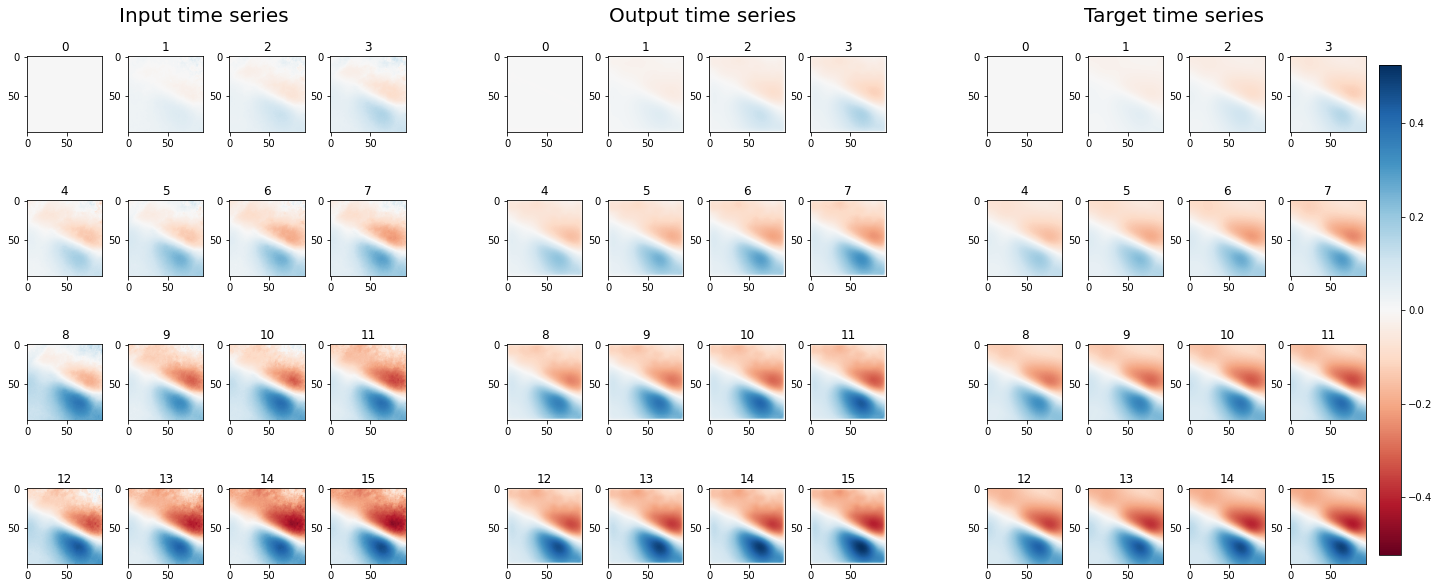

In [52]:
i = 1
x_img = X_test[i][1:]   # X_test is unscaled
targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
print("Max target deformation: ", np.max(targ_img))

plot_data_cust(x_img, targ_img, y_img, i)

Max target deformation:  0.24127792


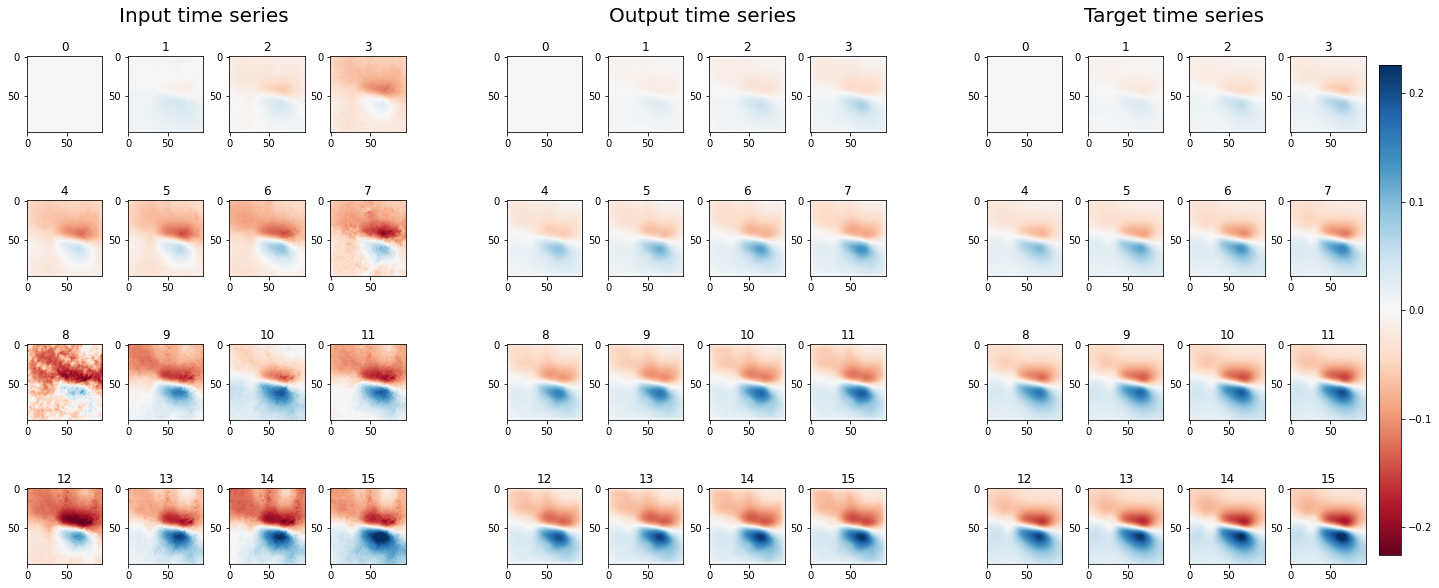

In [53]:
i = 3
x_img = X_test[i][1:]   # X_test is unscaled
targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
print("Max target deformation: ", np.max(targ_img))

plot_data_cust(x_img, targ_img, y_img, i)

Max target deformation:  0.24224372


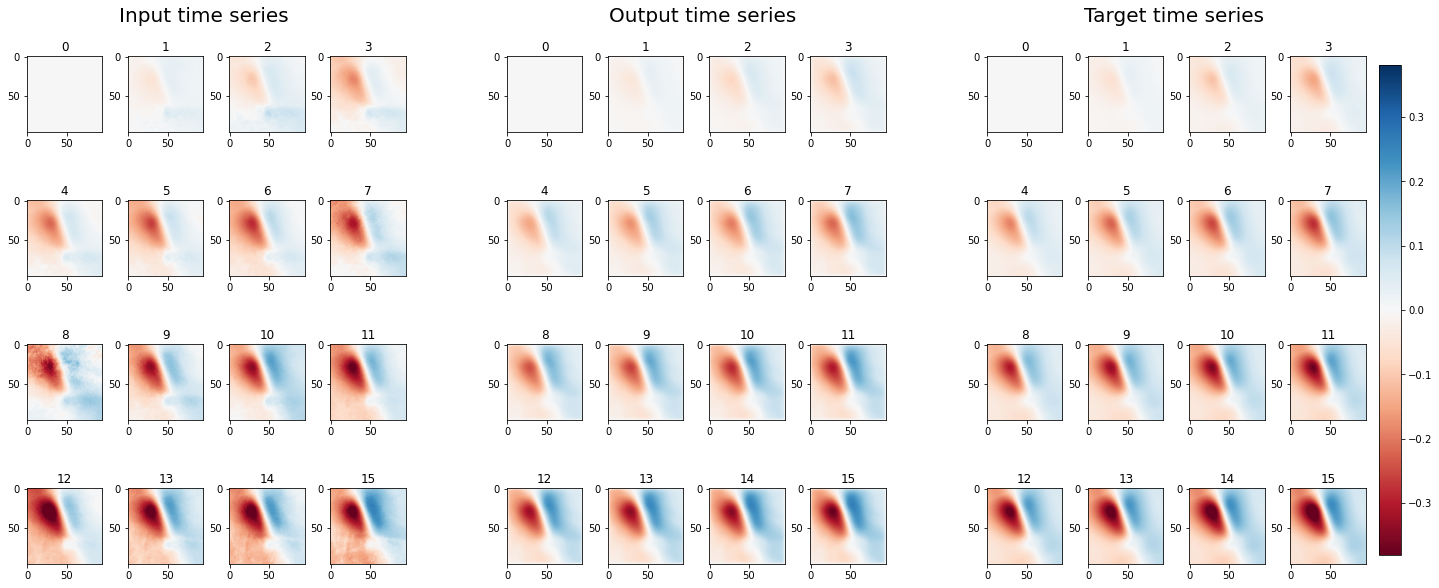

In [56]:
i = 4
x_img = X_test[i][1:]   # X_test is unscaled
targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
print("Max target deformation: ", np.max(targ_img))

plot_data_cust(x_img, targ_img, y_img, i)

Max target deformation:  0.037368968


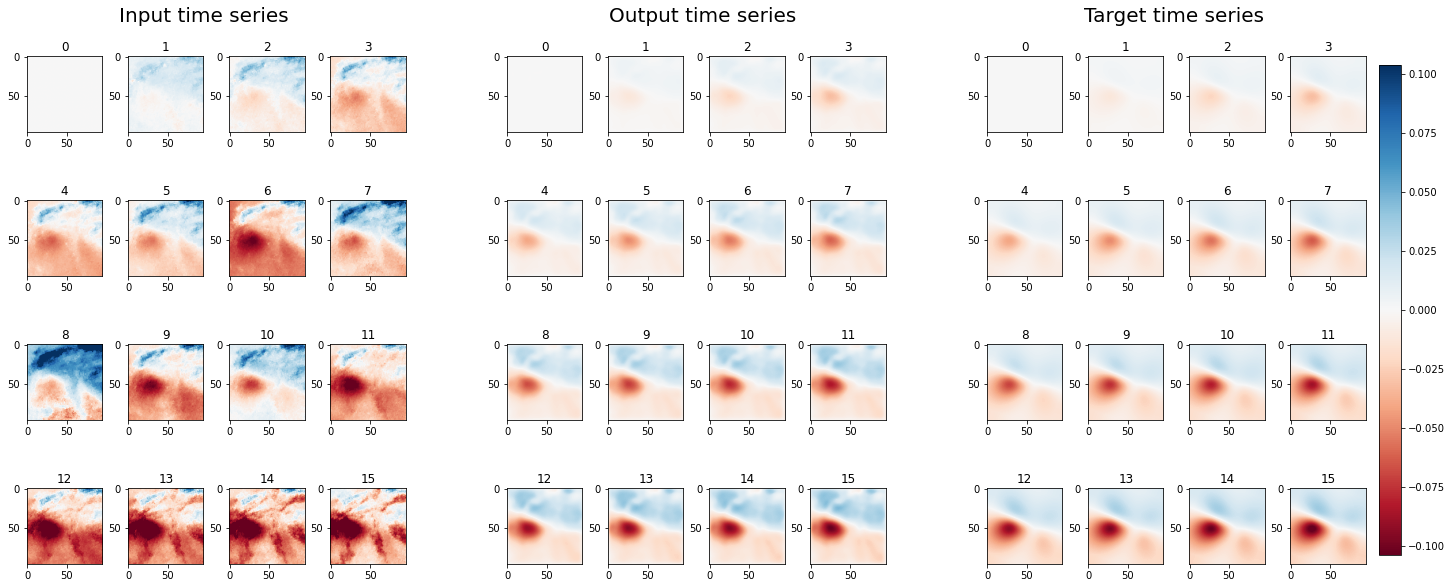

In [55]:
i = 10
x_img = X_test[i][1:]   # X_test is unscaled
targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
print("Max target deformation: ", np.max(targ_img))

plot_data_cust(x_img, targ_img, y_img, i)

Max target deformation:  0.2303591


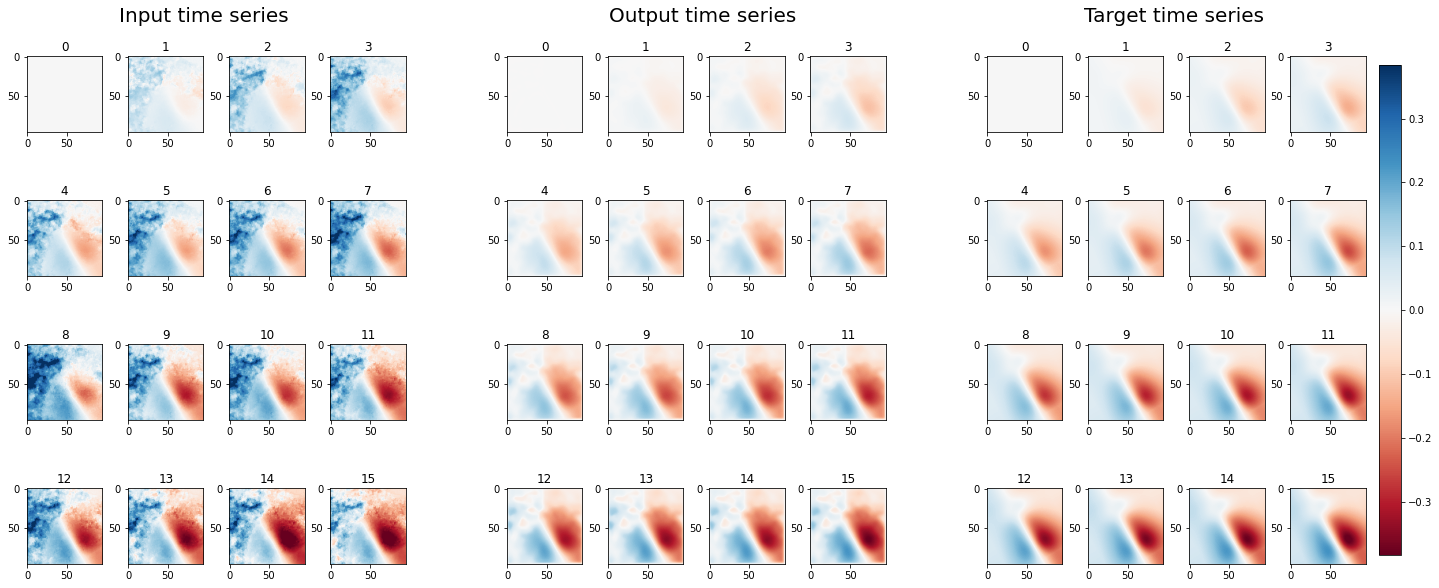

In [58]:
i = 12
x_img = X_test[i][1:]   # X_test is unscaled
targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
print("Max target deformation: ", np.max(targ_img))

plot_data_cust(x_img, targ_img, y_img, i)

Max target deformation:  0.31531128


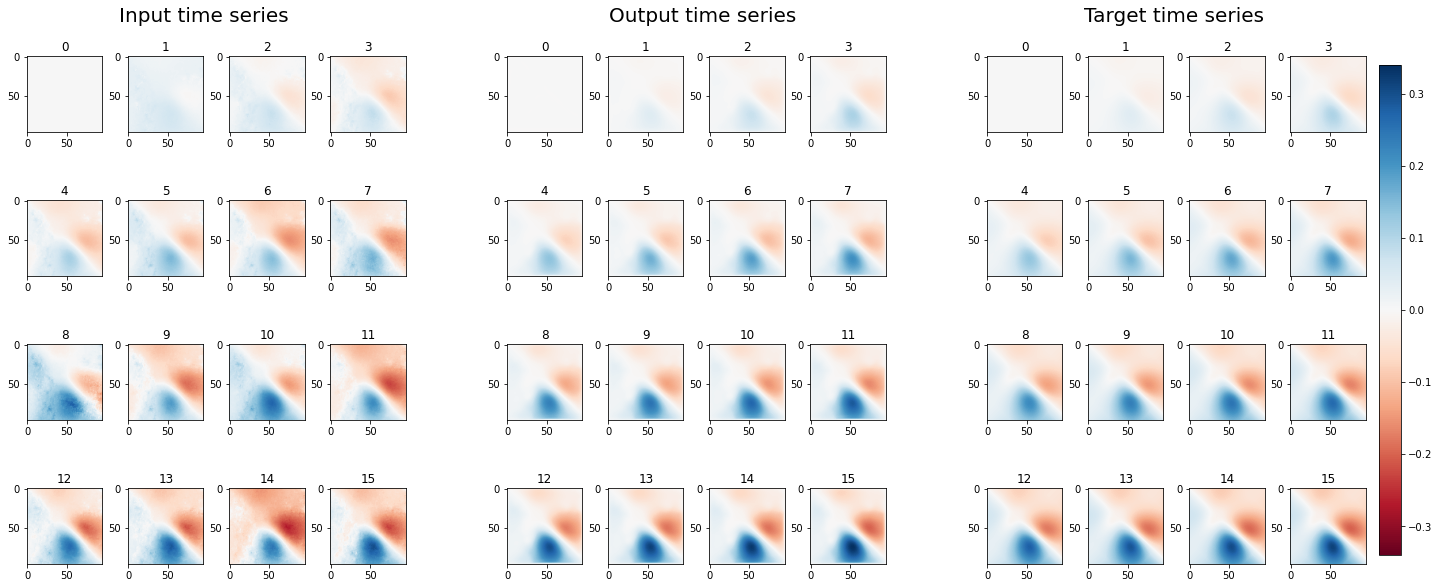

In [65]:
i = 16
x_img = X_test[i][1:]   # X_test is unscaled
targ_img = tf.transpose(y_test[i], (2, 0, 1))   # y_test is unscaled
y_img = tf.squeeze(predictions_vis[i], -1)   # predictions has been de-scaled
print("Max target deformation: ", np.max(targ_img))

plot_data_cust(x_img, targ_img, y_img, i)